# Binary Question-Answering Framework Tutorial

This notebook provides a practical guide to using the Binary QA Framework for training and evaluating models on two- and four-directional question-answering tasks. The framework supports both LSTM (TensorFlow) and Transformer (PyTorch) models.



## 1. Setting Up the Environment

First, let's import the necessary libraries and set up our environment.


In [1]:

import os
import sys
import pickle
import json
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yaml
import tensorflow as tf
import torch
import traceback

from tqdm.auto import tqdm

# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

print(f"TensorFlow version: {tf.__version__}")
print(f"PyTorch version: {torch.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")



if "src" not in sys.path:
    sys.path.append("src")
    
try:
    from src.pipeline import UnifiedPipeline
    from src.utils.experiment_tracker import ExperimentTracker
    from src.training.lstm_trainer import LSTMTrainer
    from src.training.transformer_trainer import TransformerTrainer
    from src.training.lstm_neptune_logger import LSTMNeptuneLogger
    from src.training.transformer_neptune_logger import TransformerNeptuneLogger
    print("Successfully imported framework components including trainers")
except ImportError as e:
    print(f"Error importing framework components: {e}")
    print("Make sure you're running this notebook from the project root directory")


TensorFlow version: 2.16.2
PyTorch version: 2.0.1
NumPy version: 1.26.4
Pandas version: 2.1.0
Successfully imported framework components including trainers




### Load Configuration

The framework relies on a configuration file (config.yaml) to set hyperparameters for data processing, model architecture, training, and evaluation.


In [2]:

def load_config(config_path):
    """Load configuration from YAML file."""
    with open(config_path, 'r') as f:
        return yaml.safe_load(f)

config_path = "config.yaml"
config = load_config(config_path)

print("Available datasets:")
for dataset_name in config['data']['datasets'].keys():
    print(f"  - {dataset_name}")

# configuration options :
selected_dataset = "all_2dir"  # options: "all_4dir" or "all_2dir"
selected_framework = "lstm"    # options: "lstm" or "transformer" 
run_optimization = False       # set to True to run hyperparameter optimization, False to use spesific hyperparameters from the config

print(f"\nUsing dataset: {selected_dataset}")
print(f"Using framework: {selected_framework}")
print(f"Running optimization: {run_optimization}")

hyperparams = config['hyperparameters'][selected_framework]['defaults'][selected_dataset]
print(f"\nHyperparameters for {selected_dataset} with {selected_framework}:")
for key, value in hyperparams.items():
    print(f"  - {key}: {value}")


Available datasets:
  - all_2dir
  - all_4dir

Using dataset: all_2dir
Using framework: lstm
Running optimization: False

Hyperparameters for all_2dir with lstm:
  - learning_rate: 0.001
  - batch_size: 128
  - dropout: 0.39
  - l1_regul: 5e-05
  - l2_regul: 3e-05
  - hidden_layers: 74



## 2. Loading and Inspecting Datasets

Let's examine the structure of the dataset.


In [3]:

def inspect_dataset(dataset_path):
    """Inspect a pickled dataset file to understand its structure."""
    print(f"Inspecting dataset: {dataset_path}")
    
    with open(dataset_path, 'rb') as f:
        data = pickle.load(f)
    
    print(f"Dataset contains {len(data)} keys")
    
    sample_keys = random.sample(list(data.keys()), min(3, len(data)))
    
    categories = {}
    total_stories = 0
    stories_with_metadata = 0
    
    for key in sample_keys:
        print(f"\nKey: {key}")
        pos_stories = data[key]['pos']
        neg_stories = data[key]['neg']
        
        print(f"  - Positive stories: {len(pos_stories)}")
        print(f"  - Negative stories: {len(neg_stories)}")
        
        if pos_stories:
            sample_pos = pos_stories[0]
            print("\nSample positive story:")
            print(f"  Type: {type(sample_pos)}")
            print(f"  Length: {len(sample_pos)}")
            
            if len(sample_pos) > 0 and isinstance(sample_pos[0], list):
                print(f"  Sentences: {len(sample_pos[0])}")
                print(f"  First sentence: {sample_pos[0][0] if sample_pos[0] else 'N/A'}")
            
            if len(sample_pos) > 2 and isinstance(sample_pos[2], dict):
                print(f"  Metadata: {sample_pos[2]}")
                if 'category' in sample_pos[2]:
                    print(f"  Category: {sample_pos[2]['category']}")
    
    for key, value in data.items():
        for story_list in [value['pos'], value['neg']]:
            for story in story_list:
                total_stories += 1
                if len(story) > 2 and isinstance(story[2], dict) and 'category' in story[2]:
                    stories_with_metadata += 1
                    category = story[2]['category']
                    categories[category] = categories.get(category, 0) + 1
    
    print(f"\nTotal stories: {total_stories}")
    print(f"Stories with category metadata: {stories_with_metadata} ({stories_with_metadata/total_stories*100:.1f}%)")
    
    if categories:
        print("\nCategory distribution:")
        for category, count in sorted(categories.items()):
            print(f"  - {category}: {count} stories ({count/total_stories*100:.1f}%)")
    
    return data

dataset_path = config['data']['datasets'][selected_dataset]['stories_file']
dataset = inspect_dataset(dataset_path)


Inspecting dataset: datasets_new/all_2dir.pkl
Dataset contains 893 keys

Key: (27, 48)
  - Positive stories: 1
  - Negative stories: 2

Sample positive story:
  Type: <class 'tuple'>
  Length: 3
  Sentences: 48
  First sentence: Paul walks south. 
  Metadata: {'category': 'deeper', 'num_actors': 27, 'n_sentences': 48}
  Category: deeper

Key: (13, 36)
  - Positive stories: 5
  - Negative stories: 4

Sample positive story:
  Type: <class 'tuple'>
  Length: 3
  Sentences: 36
  First sentence: Helen walks north. 
  Metadata: {'category': 'less', 'num_actors': 13, 'n_sentences': 36}
  Category: less

Key: (6, 11)
  - Positive stories: 4
  - Negative stories: 1

Sample positive story:
  Type: <class 'tuple'>
  Length: 3
  Sentences: 11
  First sentence: Daniel walks south. 
  Metadata: {'category': 'simple', 'num_actors': 6, 'n_sentences': 11}
  Category: simple

Total stories: 6836
Stories with category metadata: 6836 (100.0%)

Category distribution:
  - deeper: 1250 stories (18.3%)
  - de


### Load Train, Validation, and Test Indices

Now, let's check the train, validation, and test splits.


In [4]:

def load_indices(file_path):
    """Load indices from a JSON file."""
    if not os.path.exists(file_path):
        print(f"Warning: Indices file not found at {file_path}")
        return []
    
    with open(file_path, 'r') as f:
        indices = json.load(f)
    return indices

# load indices for the selected dataset
dataset_config = config['data']['datasets'][selected_dataset]

train_indices = load_indices(dataset_config['train_indices_file'])
valid_indices = load_indices(dataset_config['valid_indices_file'])
validb_indices = load_indices(dataset_config.get('validb_indices_file', ''))
test_indices = load_indices(dataset_config.get('test_indices_file', ''))

print(f"Train set: {len(train_indices)} examples")
print(f"Validation set A: {len(valid_indices)} examples")
print(f"Validation set B: {len(validb_indices)} examples")
print(f"Test set: {len(test_indices)} examples")


Train set: 392 examples
Validation set A: 100 examples
Validation set B: 3864 examples
Test set: 2480 examples



## 3. Initialize the Pipeline

Let's initialize the pipeline with the selected model and the Neptune experiment tracker.


In [5]:

experiment_tracker = ExperimentTracker(
    project_name=config['neptune']['project_name'],
    api_token=config['neptune']['api_token'])

# set up model directory
model_dir = config['model']['model_dir']
os.makedirs(model_dir, exist_ok=True)

# initialize pipeline
pipeline = UnifiedPipeline(
    framework=selected_framework,
    experiment_tracker=experiment_tracker,
    model_save_dir=model_dir
)

Initialized LSTMTrainer



### Prepare the Data

Let's process the data using the pipeline's prepare_data method.



In [6]:

data_info = pipeline.prepare_data(
    dataset_name=selected_dataset,
    stories_path=dataset_config['stories_file'],
    train_indices_path=dataset_config['train_indices_file'],
    valid_indices_path=dataset_config['valid_indices_file'],
    validb_indices_path=dataset_config.get('validb_indices_file', None),
    test_indices_path=dataset_config.get('test_indices_file', None),
    names=config['data']['names'],
    max_vocab_size=config['data']['max_vocab_size'],
    max_story_len=config['data']['max_story_len'],
    max_question_len=config['data']['max_question_len'],
    max_length=config['data']['max_length']
)

print(f"Prepared dataset: {selected_dataset}")
print(f"Train set: {len(data_info['train_df'])} examples")
print(f"Validation set: {len(data_info['val_df'])} examples")
if 'valb_df' in data_info:
    print(f"Secondary validation set: {len(data_info['valb_df'])} examples")
if 'test_df' in data_info:
    print(f"Test set: {len(data_info['test_df'])} examples")
print(f"Vocabulary size: {data_info['vocab_size']}")


# this helper function fixes some visualization issues in the codebase.

import builtins
original_print = builtins.print

def safe_print(*args, **kwargs):
    try:
        original_print(*args, **kwargs)
    except TypeError as e:
        if "unhashable type: 'slice'" in str(e):
            if args and isinstance(args[0], str):
                fixed_msg = args[0].replace(
                    "sizes: {list(sizes.items())[:3]", 
                    "sizes: {list(sizes.items())[0:3] if sizes else []"
                )
                original_print(fixed_msg, *args[1:], **kwargs)
            else:
                original_print("(Error displaying slice in output)", **kwargs)
        else:
            original_print(f"Print error: {str(e)}", **kwargs)

def fix_visualization_issue():
    """
    Fix for the main issue: the NoneType error in evaluation functions
    and the mismatch between evaluation results and visualization expectations.
    """
    # apply patch to print function
    builtins.print = safe_print
    
    from src.training.lstm_trainer import LSTMTrainer
    from src.training.transformer_trainer import TransformerTrainer
    
    return {"safe_print": safe_print}

# execute this function to apply the fixes
fixed_functions = fix_visualization_issue()



Step 1: Loading stories from datasets_new/all_2dir.pkl
Loaded dataset with 893 tuple keys
  - Loaded dataset with 6836 stories
  - Detected direction type: 2dir
Step 2: Processing all tuple keys and mapping to density categories
Processing all tuple categories and mapping to density categories
  Processed 893 tuple keys into 6836 stories
  Density category distribution:
    - deeper: 1250 stories (18.3%)
    - dense: 1250 stories (18.3%)
    - less: 1250 stories (18.3%)
    - simple: 1836 stories (26.9%)
    - superdense: 1250 stories (18.3%)
  - Mapped dataset has 6836 stories
Step 2b: Adding dataset_name to metadata
Step 3: Creating DataFrame
Created DataFrame with 6836 story dictionaries
Category distribution in DataFrame:
  - simple: 1836 stories (26.9%)
  - dense: 1250 stories (18.3%)
  - less: 1250 stories (18.3%)
  - superdense: 1250 stories (18.3%)
  - deeper: 1250 stories (18.3%)
  - Created DataFrame with 6836 rows
  - Category distribution in DataFrame:
    * simple: 1836 st

## 4. Unified Training and Evaluation Workflow

This section defines a unified function to handle both optimization and direct training options.



In [7]:

def streamlined_workflow(config, pipeline, data_info, selected_framework, model_dir, 
                         mode='train', n_trials=3, epochs_per_trial=5, early_stopping_trials=2,
                         fixed_hyperparams=None, num_epochs=5):
    """
    Unified workflow function that handles both optimization-to-visualization and
    config-train-to-visualization paths.
    """
    current_print = builtins.print
    builtins.print = safe_print
    
    try:
        data_info['dataset_name'] = selected_dataset  
        data_info['train_df']['dataset_name'] = selected_dataset
        data_info['val_df']['dataset_name'] = selected_dataset
        
        metadata_train = data_info['train_df']
        metadata_val = data_info['val_df']
        
        # setup appropriate trainer
        if selected_framework == 'lstm':
            trainer = LSTMTrainer(
                experiment_tracker=experiment_tracker,
                save_directory=model_dir
            )
            print(f"Initialized LSTMTrainer for {mode} workflow")
        else:
            trainer = TransformerTrainer(
                experiment_tracker=experiment_tracker,
                save_directory=model_dir
            )
            print(f"Initialized TransformerTrainer for {mode} workflow")
        
        # BRANCH 1: Optimization Workflow
        if mode == 'optimize':
            print(f"\n{'='*70}\nRUNNING OPTIMIZATION WORKFLOW\n{'='*70}")
            
            optimization_dir = os.path.join(model_dir, 'optimization')
            os.makedirs(optimization_dir, exist_ok=True)
            
            # start optimization run
            experiment_tracker.start_run(
                run_name=f"{selected_dataset}_{selected_framework}_optimization",
                parameters={'framework': selected_framework, 'n_trials': n_trials},
                tags=[selected_dataset, selected_framework, 'optimization']
            )
            
            from full_opt_workflow import optimize_model
            best_model, best_model_path, best_hyperparams = optimize_model(
                config=config,
                pipeline=pipeline,
                data_info=data_info,
                selected_framework=selected_framework,
                model_dir=model_dir,
                n_trials=n_trials,
                early_stopping_trials=early_stopping_trials,
                epochs_per_trial=epochs_per_trial
            )
            
            experiment_tracker.end_run()
            
            print(f"\nBest hyperparameters found:")
            for key, value in best_hyperparams.items():
                print(f"  - {key}: {value}")
            
            print(f"\nBest model saved at: {best_model_path}")
            
        # BRANCH 2: Direct Training Workflow
        else:  # mode == 'train'
            print(f"\n{'='*70}\nRUNNING DIRECT TRAINING WORKFLOW\n{'='*70}")
            
            # create model using specified hyperparameters
            hyperparams = fixed_hyperparams
            print(f"Creating {selected_framework} model with provided hyperparameters")
            model = pipeline.create_model(data_info, hyperparams)
            
            # start training run
            experiment_tracker.start_run(
                run_name=f"{selected_dataset}_{selected_framework}_direct_training",
                parameters={**hyperparams, 'dataset': selected_dataset},
                tags=[selected_dataset, selected_framework, 'direct_training']
            )
            
            # train the model
            print(f"Training {selected_framework} model for {num_epochs} epochs")
            training_results = trainer.train(
                model=model,
                train_data=data_info['train_data'],
                val_data=data_info['val_data'],
                metadata_train=metadata_train,
                metadata_val=metadata_val,
                hyperparams=hyperparams,
                epochs=num_epochs
            )
            
            experiment_tracker.end_run()
            
            print(f"Training complete!")
            print(f"Best validation accuracy: {training_results['best_val_accuracy']:.4f}")
            print(f"Best epoch: {training_results['best_epoch']}")
            
            # save the best model
            best_model_path = os.path.join(model_dir, f"training/{selected_dataset}_{selected_framework}_best_model.{'weights.h5' if selected_framework == 'lstm' else 'pt'}")
            os.makedirs(os.path.dirname(best_model_path), exist_ok=True)
            
            saved_path = trainer.save_model(model, best_model_path)
            if saved_path:
                print(f"Best model saved to: {saved_path}")
            else:
                print("Failed to save the best model")
            
            best_model = model
            best_hyperparams = hyperparams
        
        print(f"\n{'='*70}\nRUNNING EVALUATION AND VISUALIZATION\n{'='*70}")
        
        # start evaluation run
        experiment_tracker.start_run(
            run_name=f"{selected_dataset}_{selected_framework}_evaluation",
            parameters={'dataset': selected_dataset, 'framework': selected_framework},
            tags=[selected_dataset, selected_framework, 'evaluation']
        )
        
        # get evaluation datasets
        dataset_types = ['train']
        if 'val_data' in data_info:
            dataset_types.append('valid')
        if 'valb_data' in data_info:
            dataset_types.append('valid_comp')
        if 'test_data' in data_info:
            dataset_types.append('test')
        
        print(f"Evaluating on dataset types: {', '.join(dataset_types)}")
        
        # evaluate and prepare visualization data
        from full_opt_workflow import prepare_evaluation_data
        eval_results = prepare_evaluation_data(
            data_info=data_info,
            model=best_model,
            trainer=trainer,
            dataset_types=dataset_types
        )
        
        # run visualization
        try:
            print(f"\nGenerating visualizations...")
            from visualisation import create_model_evaluation_visualizations
            create_model_evaluation_visualizations(
                data_info=data_info,
                eval_results=eval_results,
                model_name=selected_framework,
                dataset_name=selected_dataset
            )
            print("Visualization completed successfully!")
        except Exception as e:
            print(f"Error in visualization: {str(e)}")
            traceback.print_exc()
        
        experiment_tracker.end_run()
        
        return {
            'best_model': best_model,
            'best_model_path': best_model_path,
            'best_hyperparams': best_hyperparams,
            'evaluation_results': eval_results,
            'data_info': data_info
        }
        
    except Exception as e:
        print(f"Error in workflow: {str(e)}")
        traceback.print_exc()
        return {'error': str(e)}
    
    finally:
        builtins.print = current_print

Initialized LSTMTrainer for train workflow

RUNNING DIRECT TRAINING WORKFLOW
Creating lstm model with provided hyperparameters
Creating TensorFlow LSTM model:
  - Vocabulary size: 55
  - Max story length: 450
  - Max question length: 5
  - Hidden layers: 74
  - Dropout: 0.39


2025-03-11 00:43:26.309613: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2025-03-11 00:43:26.309641: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-03-11 00:43:26.309652: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-03-11 00:43:26.309676: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-11 00:43:26.309698: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.


Model created successfully


[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/kat/simple-rnn/e/SIM-12197
Training lstm model for 100 epochs
DEBUG - metadata_train type: <class 'pandas.core.frame.DataFrame'>
Using sanitized dataset name 'all_2dir' for model saving
Creating LSTMNeptuneLogger for detailed metrics tracking
LSTMNeptuneLogger init:
  - Metadata train type: <class 'pandas.core.frame.DataFrame'>
  - Metadata val type: <class 'pandas.core.frame.DataFrame'>
  - Metadata train columns: ['story', 'label', 'category', 'story_type', 'original_tuple', 'num_actors', 'num_sentences', 'dataset_name']
  - Train categories: ['simple']
  - Metadata val columns: ['story', 'label', 'category', 'story_type', 'original_tuple', 'num_actors', 'num_sentences', 'dataset_name']
  - Val categories: ['simple']
Model will be saved to pattern: models/raw/all_2dir_lstm_model_SIM-12197_epoch_{epoch:02d}.weights.h5


0epoch [00:00, ?epoch/s]


Starting LSTM training for 100 epochs:


Training:   0%|          | 0/100 [00:00<?, ?epoch/s]

2025-03-11 00:43:28.730301: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


Logging basic metrics for epoch 0...

NEW BEST EPOCH: 0 with validation accuracy: 0.4300

CURRENT TOP 3 EPOCHS:
  #1: Epoch 0 - Validation Accuracy: 0.4300
Computing detailed accuracies for epoch 0...
Found exact column match: 'category'
Found exact column match: 'num_actors'
Using categories: ['simple']
Using noun counts: [4, 5, 6, 7, 8]
Logging basic metrics for epoch 1...

NEW BEST EPOCH: 1 with validation accuracy: 0.4500

CURRENT TOP 3 EPOCHS:
  #1: Epoch 1 - Validation Accuracy: 0.4500
  #2: Epoch 0 - Validation Accuracy: 0.4300
Computing detailed accuracies for epoch 1...
Found exact column match: 'category'
Found exact column match: 'num_actors'
Using categories: ['simple']
Using noun counts: [4, 5, 6, 7, 8]
Logging basic metrics for epoch 2...
CURRENT TOP 3 EPOCHS:
  #1: Epoch 2 - Validation Accuracy: 0.4500
  #2: Epoch 1 - Validation Accuracy: 0.4500
  #3: Epoch 0 - Validation Accuracy: 0.4300
Computing detailed accuracies for epoch 2...
Found exact column match: 'category'
F

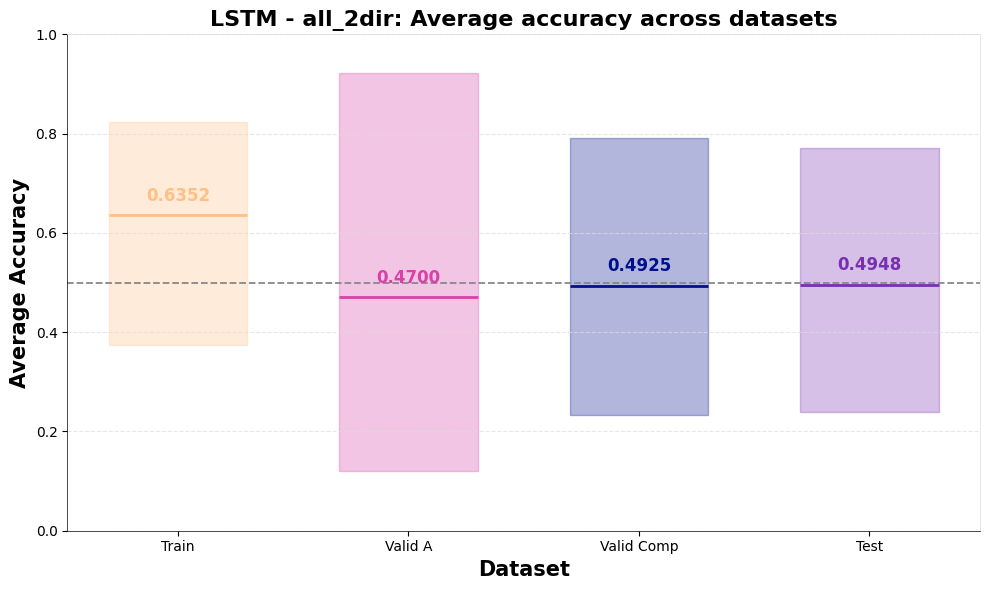


Creating category breakdown plots for each dataset...
  Processing Train...


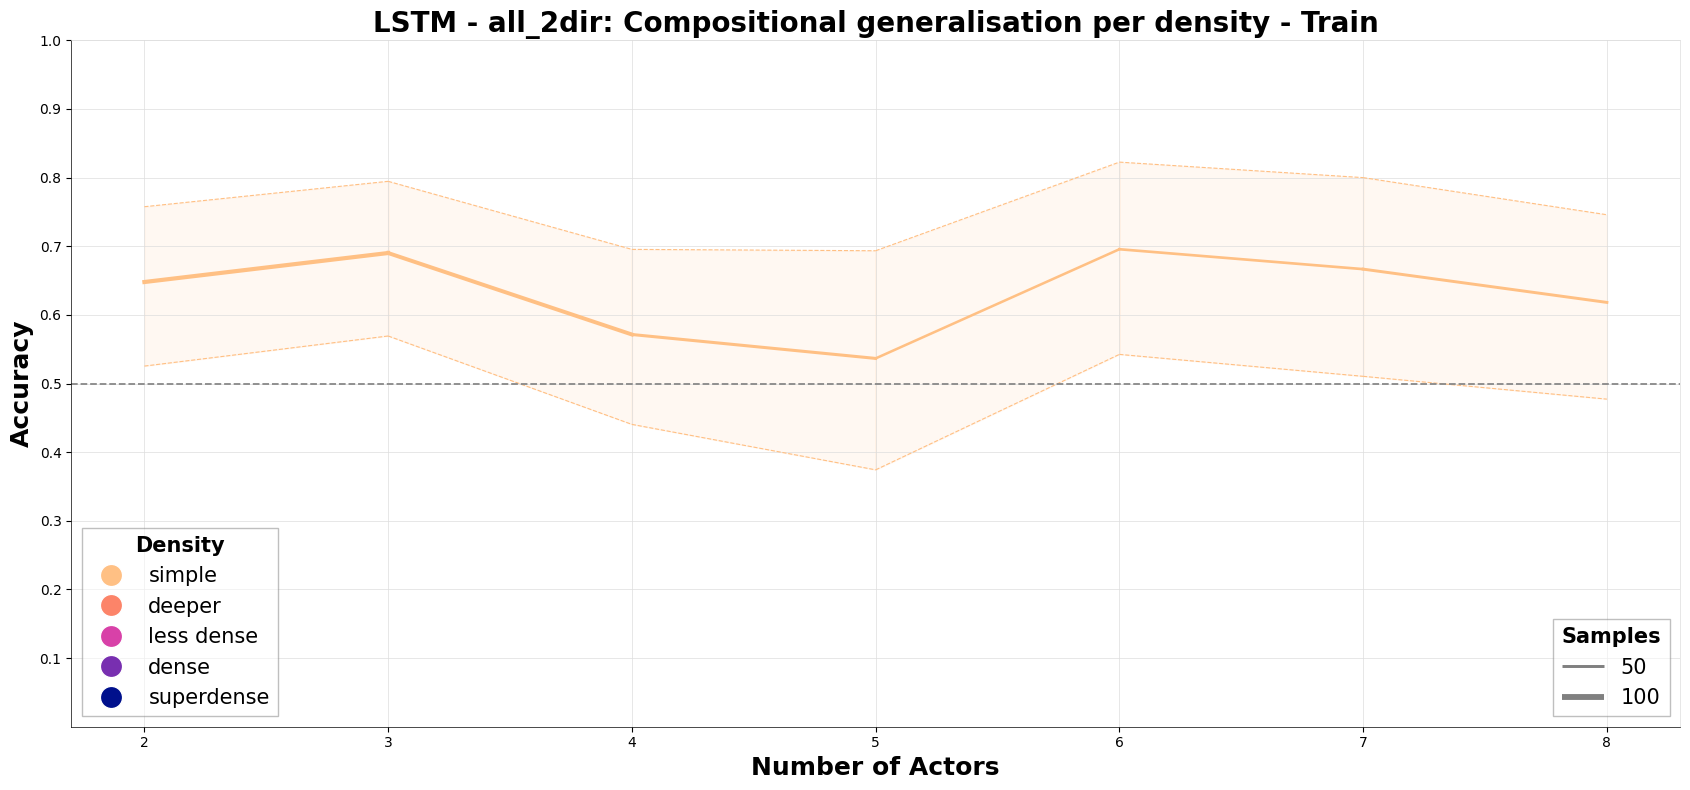

  Processing Valid A...


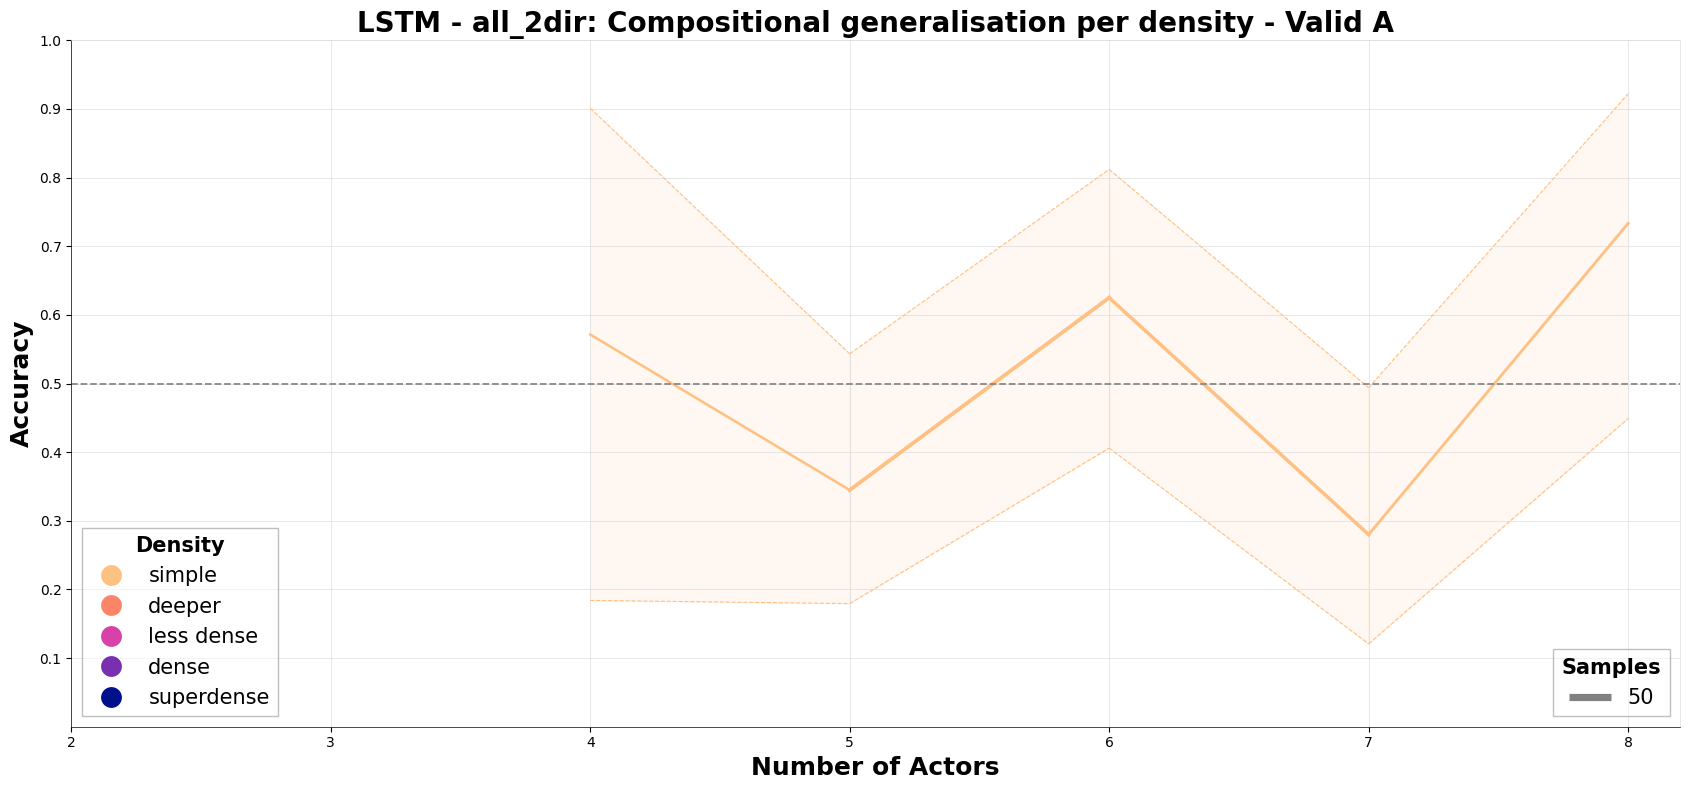

  Processing Valid Comp...


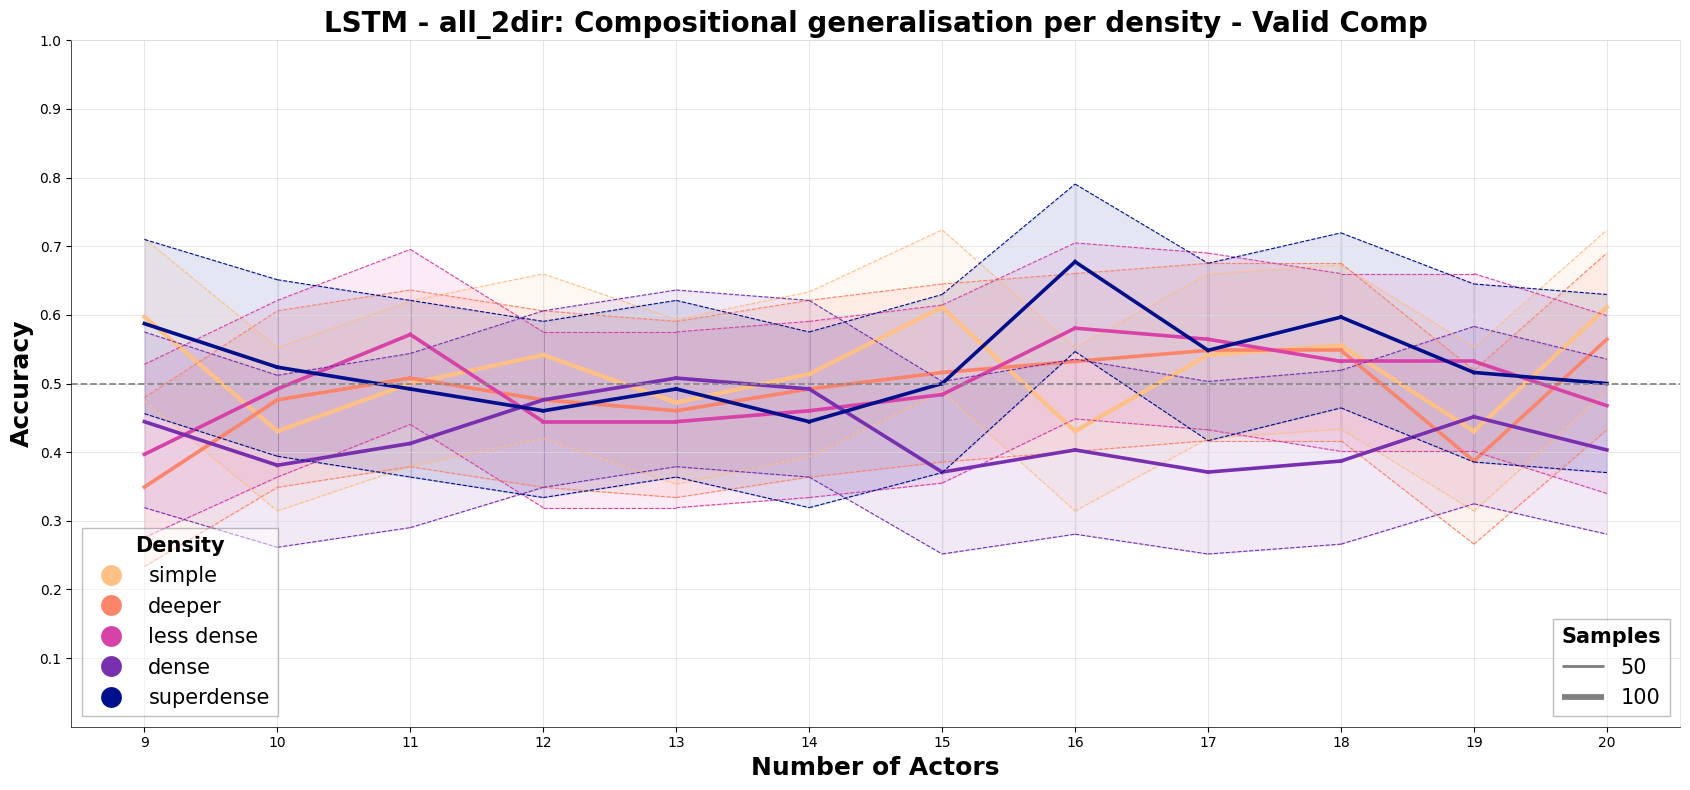

  Processing Test...


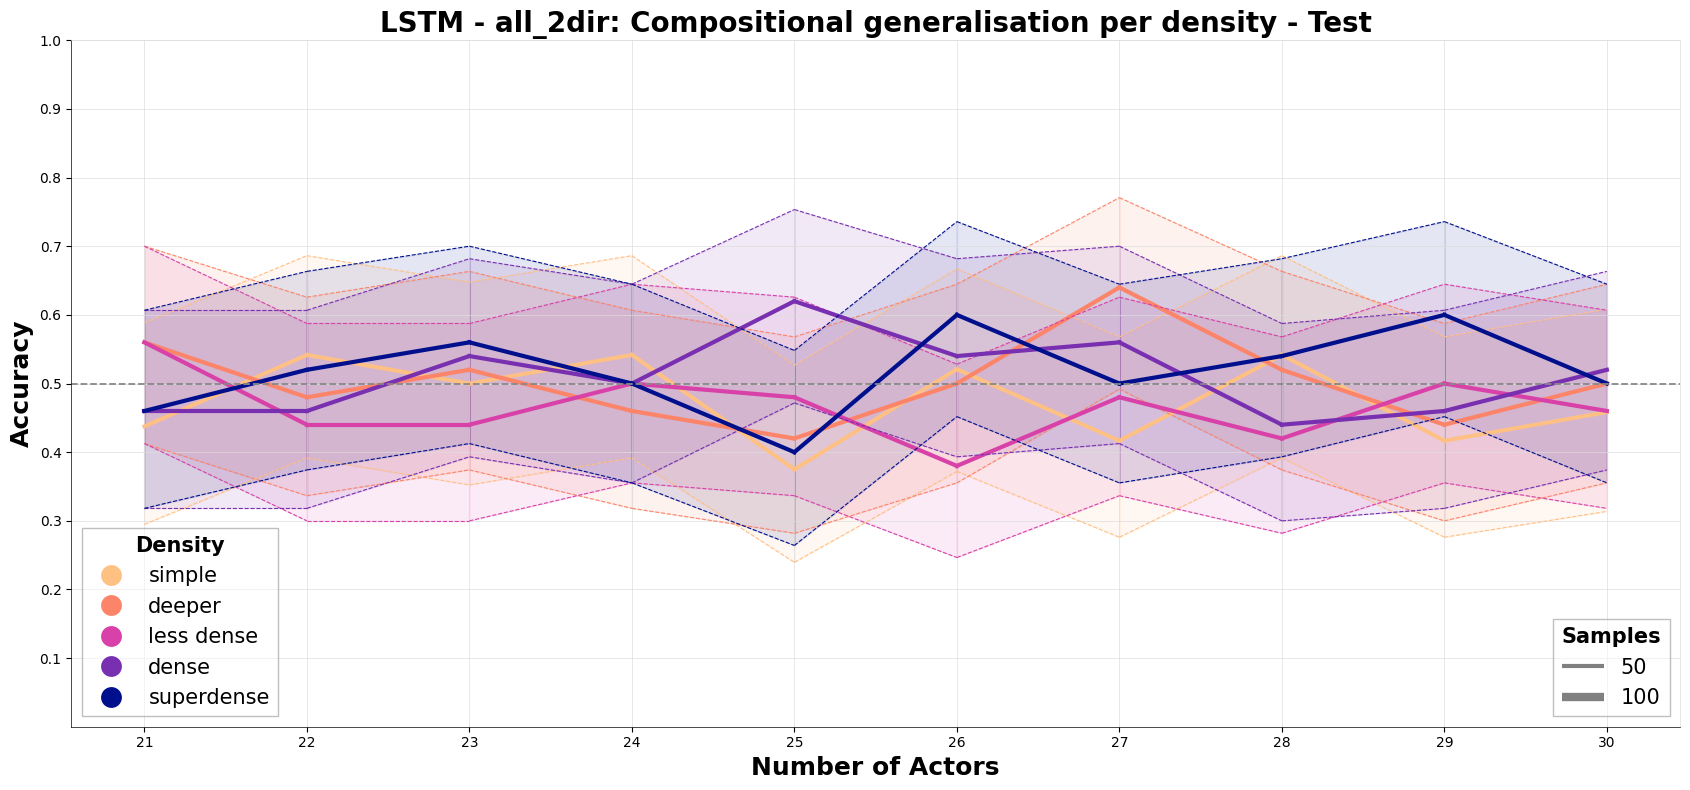


Creating comprehensive analysis plot...


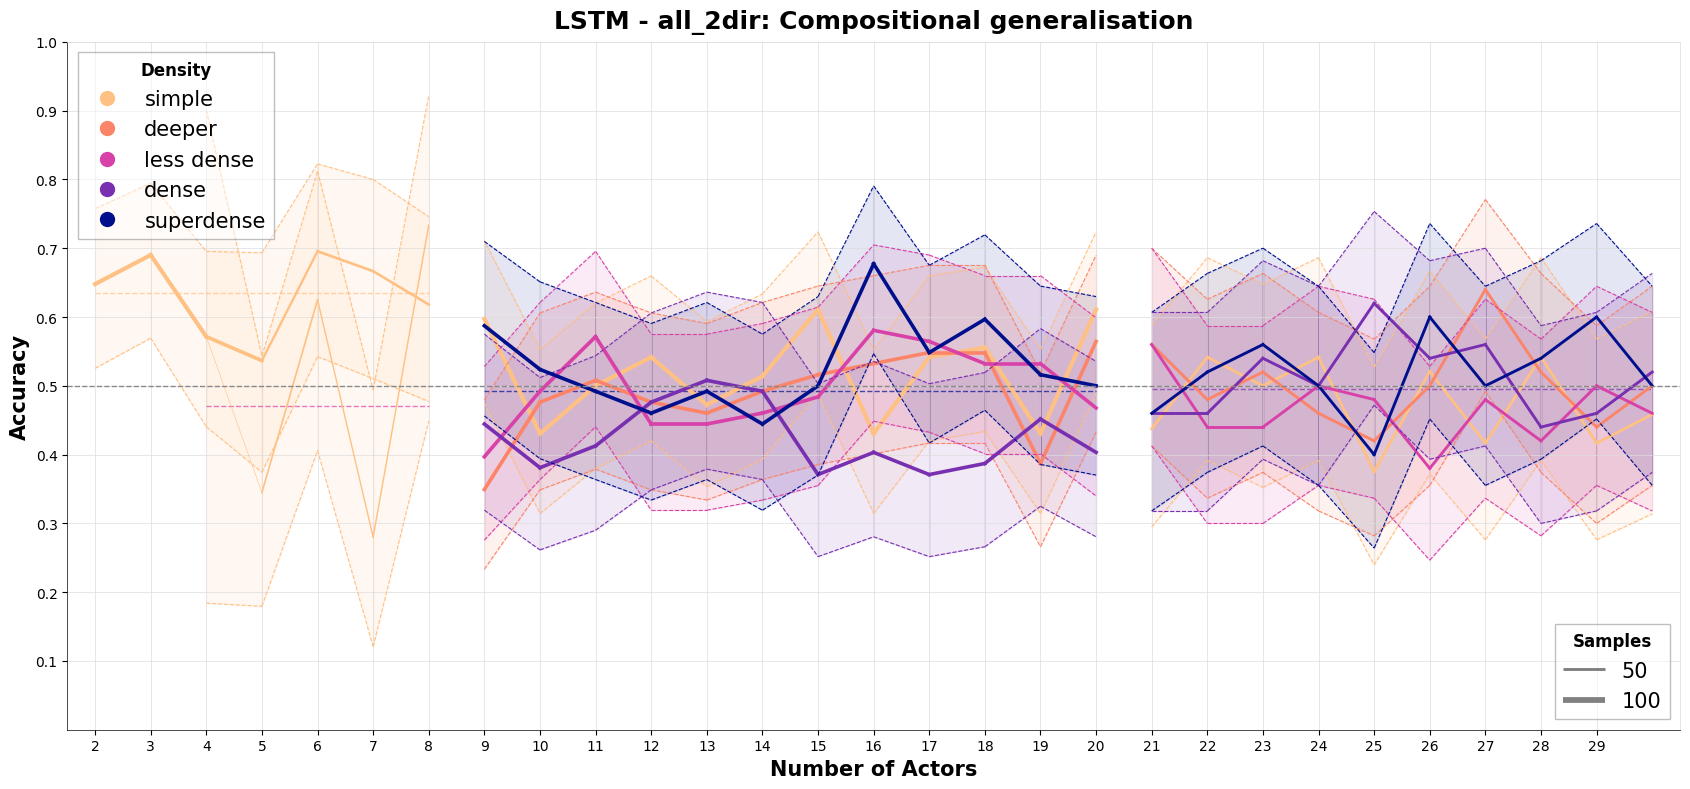


All visualizations complete.
Visualization completed successfully!
[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/kat/simple-rnn/e/SIM-12198/metadata


In [8]:


### Run the Selected Workflow

# choose between optimization or direct training by setting the `run_optimization` variable.

if run_optimization:
    workflow_results = streamlined_workflow(
        config=config,
        pipeline=pipeline,
        data_info=data_info,
        selected_framework=selected_framework,
        model_dir=model_dir,
        mode='optimize',
        n_trials=20,  # number of optimization trials
        epochs_per_trial=100,  # epochs per trial
        early_stopping_trials=2  # early stopping parameter
    )
else:
    workflow_results = streamlined_workflow(
        config=config,
        pipeline=pipeline,
        data_info=data_info,
        selected_framework=selected_framework,
        model_dir=model_dir,
        mode='train',
        fixed_hyperparams=hyperparams,
        num_epochs=100  # number of training epochs
    )



## 5. Display Model Architecture

Examine the model architecture and hyperparameters.


In [9]:


if 'best_model' in workflow_results:
    model = workflow_results['best_model']
    
    if selected_framework == 'lstm':
        print("LSTM Model Architecture:")
        model.model.summary()
        
        print("\nKey LSTM Model Parameters:")
        print(f"  - Vocabulary Size: {model.vocab_size}")
        print(f"  - Max Story Length: {model.max_story_len}")
        print(f"  - Max Question Length: {model.max_question_len}")
        print(f"  - Hidden Layers: {model.hyperparams.get('hidden_layers', 74)}")
        print(f"  - Dropout Rate: {model.hyperparams.get('dropout', 0.39)}")
        print(f"  - Learning Rate: {model.hyperparams.get('learning_rate', 0.001)}")
        print(f"  - L1 Regularization: {model.hyperparams.get('l1_regul', 0.00005)}")
        print(f"  - L2 Regularization: {model.hyperparams.get('l2_regul', 0.00003)}")
    else:  # transformer
        print("Transformer Model Architecture:")
        print(model)
        
        total_params = sum(p.numel() for p in model.parameters())
        trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
        
        print(f"\nTotal parameters: {total_params:,}")
        print(f"Trainable parameters: {trainable_params:,}")
        
        print("\nKey Transformer Model Parameters:")
        print(f"  - Model Dimension (d_model): {model.d_model}")
        try:
            print(f"  - Number of Attention Heads: {model.transformer_encoder.layers[0].self_attn.num_heads}")
            print(f"  - Number of Encoder Layers: {len(model.transformer_encoder.layers)}")
            print(f"  - Dropout Rate: {model.transformer_encoder.layers[0].dropout.p}")
        except Exception as e:
            print(f"  - Could not access all transformer parameters: {str(e)}")
else:
    print("No model available to display architecture")

print("\nModel training and evaluation complete!")


LSTM Model Architecture:


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 450)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 5)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 74)        │     44,792 │ input_layer[0][0] │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 74)        │     44,792 │ input_layer_1[0]… │
│ (Sequential)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 148)       │          0 │ sequential[0][0], │
│ (Concatenate)       │                   │            │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 74)        │     11,026 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 74)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         75 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 302,057 (1.15 MB)

 Trainable params: 100,685 (393.30 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 201,372 (786.61 KB)


Key LSTM Model Parameters:
  - Vocabulary Size: 57
  - Max Story Length: 450
  - Max Question Length: 5
  - Hidden Layers: 74
  - Dropout Rate: 0.39
  - Learning Rate: 0.001
  - L1 Regularization: 5e-05
  - L2 Regularization: 3e-05

Model training and evaluation complete!
